# Business Ties

Can we piece the business community/ economy of Eigg together from data online

In [1]:
%matplotlib inline
import sys
sys.path.insert(1,'../Utilities')
# notebook
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import networkx as nx
import json
from math import sin, cos, sqrt, atan2, radians
from utils import *
from data import *
#make the graphs bigger
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24


Bad key "text.kerning_factor" on line 4 in
C:\Users\davie\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

In [3]:
def getTouristOrgs():
    # Assumption; cafe is not tourism driven since residents will also regularly use
    return ["Craigard Teas", "Eigg Yurts", "TIGH AN SITHEAN", "Tophouse", "Selkie Explorers", "Eigg Adventures", "Eigg Camping Pods", "Kildonnan House", "Sweeney's Bothy", "The Bothy Cuagach", "Eigg Huts", "Eigg Shed", "Sweeney's Bothy", "Eddie's Eigg Croft", "Eigg Huts", "Glebe Barn", "Equilibrium Eigg Massage Therapy", "Eigg Organics", "Lagerona"]

def involvedInTourism():
    relationships = {}
    tourismOrgSet = set(getTouristOrgs())
    net = customByBusiness()
    for item in net:
        entireSet = set(net[item])
        relationships[item] = 1 if item in tourismOrgSet else 0
    relationships['Small Isles Medical Centre'] = 1
    return relationships

In [4]:
def buildDirectLinkNetOnly():
    G = nx.Graph()
    
    data = customByBusiness()
        
    names = data.keys()
    for k,i in enumerate(names): G.add_node(i)
    G.add_node('Small Isles Medical Centre')
        
    for name1 in names:
        connects = data[name1]
        for item in connects:
            G.add_edge(name1,item)
    
    labels={}
    for k,i in enumerate(names): labels[i] = i
    labels['Small Isles Medical Centre'] = 'Small Isles Medical Centre'
    return G, labels

def plotGraph(G,labels,colors=None):
    pos=nx.spring_layout(G,k=1)
    nx.draw(G,pos,node_color=colors)
    for label in pos:
        x,y = pos[label]
        plt.text(x,y+0.035,s=labels[label],horizontalalignment='center',fontsize=12)

[[   0.         2920.93805139 2436.25569637    0.            0.
     0.         2436.25569637    0.         1654.56286926 1954.44384059
  1917.19412292 2218.21636322 2218.21636322    0.         2914.99324104
  1499.36094148 1499.36094148 2914.99324104    0.         2186.75917592
  1922.30850449    0.            0.           90.7684146  2859.56468137
     0.        ]
 [2920.93805139    0.          648.64146156 2920.93805139 2920.93805139
  2920.93805139  648.64146156 2920.93805139 1266.59151233 1058.63896539
  4819.72620091 5052.94408118 5052.94408118 2920.93805139   32.32889456
  1458.2817318  1458.2817318    32.32889456 2920.93805139 5052.43610513
  1358.81119607 2920.93805139 2920.93805139 2833.84365898  218.82562684
  2920.93805139]
 [2436.25569637  648.64146156    0.         2436.25569637 2436.25569637
  2436.25569637    0.         2436.25569637  838.40652321  483.64396539
  4353.30139823 4629.23414795 4629.23414795 2436.25569637  663.60713159
  1114.63996188 1114.63996188  663.607

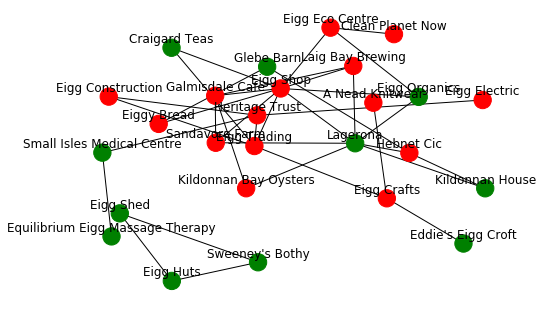

In [4]:
inTourism = involvedInTourism()
G,labels = buildDirectLinkNetOnly()
remove = [node for node,degree in G.degree() if degree == 0]
G.remove_nodes_from(remove)
colors = ["green" if inTourism[x] == 1 else "red" for x in G.nodes()]
plotGraph(G,labels,colors)

locs = inferredBusinessLocations()
locs['A Nead Knitwear'] = locs['A Nead Knitwear'.upper()]
locs['Small Isles Medical Centre'] = locs['Heritage Trust']

M = np.zeros((len(G),len(G)))

for kf,from_ in enumerate(G.nodes()):
    for kt,to_ in enumerate(G.nodes()):
        dist = 0
        if from_ != to_: 
            loc1 = toUsableLatLon(locs[from_])
            loc2 = toUsableLatLon(locs[to_])
            dist = seperationInMetres(loc1,loc2)
        
        M[kf,kt] = dist

print(M)

saveGraphToFile(G,'noElec.txt')
labelsInOrder = list(G.nodes())
attributesInOrder = list(map(lambda x: inTourism[x],G.nodes()))
np.savetxt('noElecLabels.txt', labelsInOrder, '%s')
np.savetxt('noElecAttr.txt', attributesInOrder, "%s")
np.savetxt('noElecDist.txt',M,"%f")

In [5]:
def buildNamedBusinessGraph(inferred=False):
    G = nx.Graph()
    
    data = uninferredNamesGraph()
    if inferred:
        data = inferredNamesGraph()
        
    #data = customByBusiness()
                
    names = data.keys()
    for k,i in enumerate(names): G.add_node(i)
        
    for name1 in names:
        for name2 in names:
            if name1 != name2 and len(list(set(data[name1]) & set(data[name2]))):
                G.add_edge(name1,name2)
    
    labels={}
    for k,i in enumerate(names): labels[i] = i
    return G, labels

def buildBusinessGraph(inferred=False):
    G = nx.Graph()
    data = uninferredNamesGraph()
    if inferred:
        data = inferredNamesGraph()
    
    names = data.keys()
    businesses = list(Counter([item for sublist in data.values() for item in sublist]).keys())
    
    businessMembers = defaultdict(list)
    for b in businesses:
        for name in names:
            if b in data[name]:
                businessMembers[b].append(name)
            
    businessList = businessMembers.keys()
    for k,i in enumerate(businessList): G.add_node(i)
    for b1 in businessList:
        for b2 in businessList:
            if b1 != b2 and len(list(set(businessMembers[b1]) & set(businessMembers[b2]))):
                G.add_edge(b1,b2)
    
    labels={}
    for k,i in enumerate(businessList): labels[i] = i
    return G, labels

def poliFn(companiesForPerson):
    buildStr = ""
    buildStr += str(int("Heritage Trust" in companiesForPerson)) + " "
    buildStr += str(int("Eigg Electric" in companiesForPerson)) + " "
    buildStr += str(int("Eigg Construction" in companiesForPerson)) + " "
    buildStr += str(int("Eigg Trading" in companiesForPerson))
    
    return buildStr

def saveComplexPoliticalAttributes(G,dataDict):
    labelsInOrder = list(G.nodes())
    attributesInOrder = list(map(lambda x: poliFn(dataDict[x]),G.nodes()))
    np.savetxt('privateNetAttrLabels.txt', labelsInOrder, '%s')
    np.savetxt('privateNetAttrAttributes.txt', attributesInOrder, "%s")
    
def saveGraphToFile(G, filename="testing.txt"):
    file_ = nx.to_numpy_matrix(G)
    labelsInOrder = list(G.nodes())
    np.savetxt('testingLabs.txt', labelsInOrder, '%s')
    np.savetxt(filename,file_, "%d") 

62


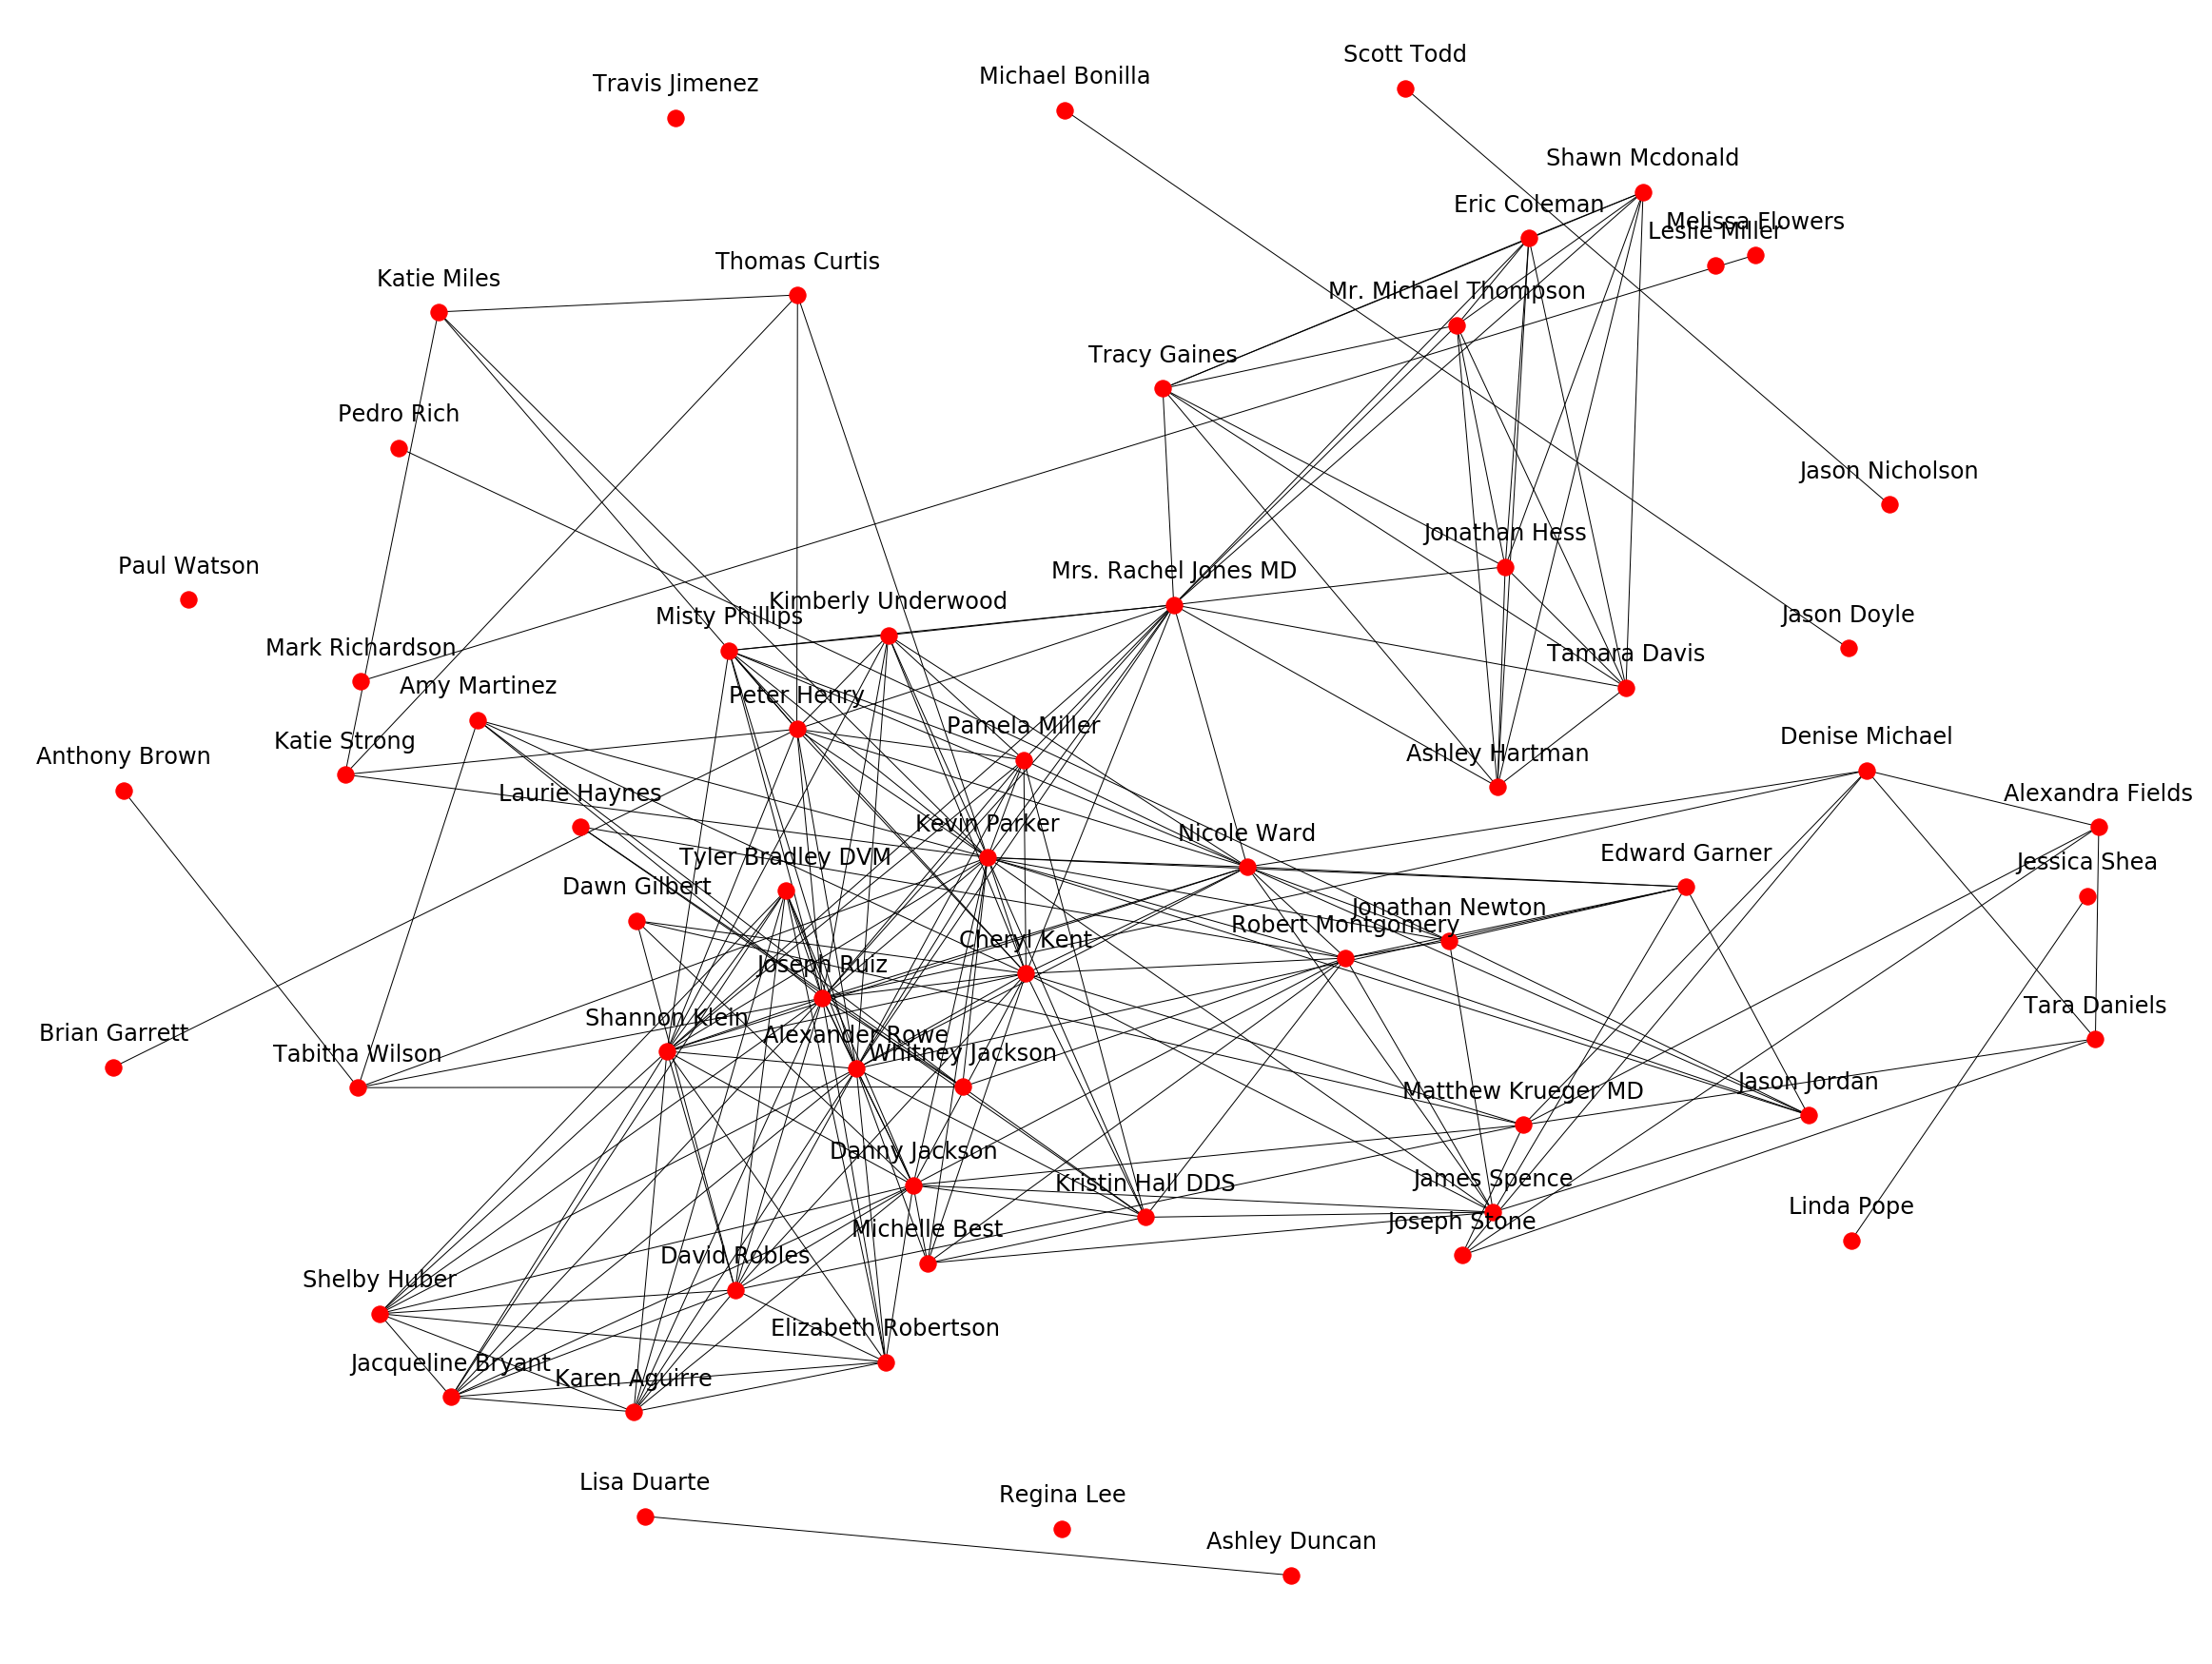

In [11]:
G, labels= buildNamedBusinessGraph()
print(len(G.degree))
pos=nx.spring_layout(G,k=1)
#nx.draw_networkx_labels(G,pos,labels,font_size=16)
nx.draw(G,pos,node_color='red')
saveGraphToFile(G)
for label in pos:
    x,y = pos[label]
    plt.text(x,y+0.035,s=label,horizontalalignment='center',fontsize=24)

62


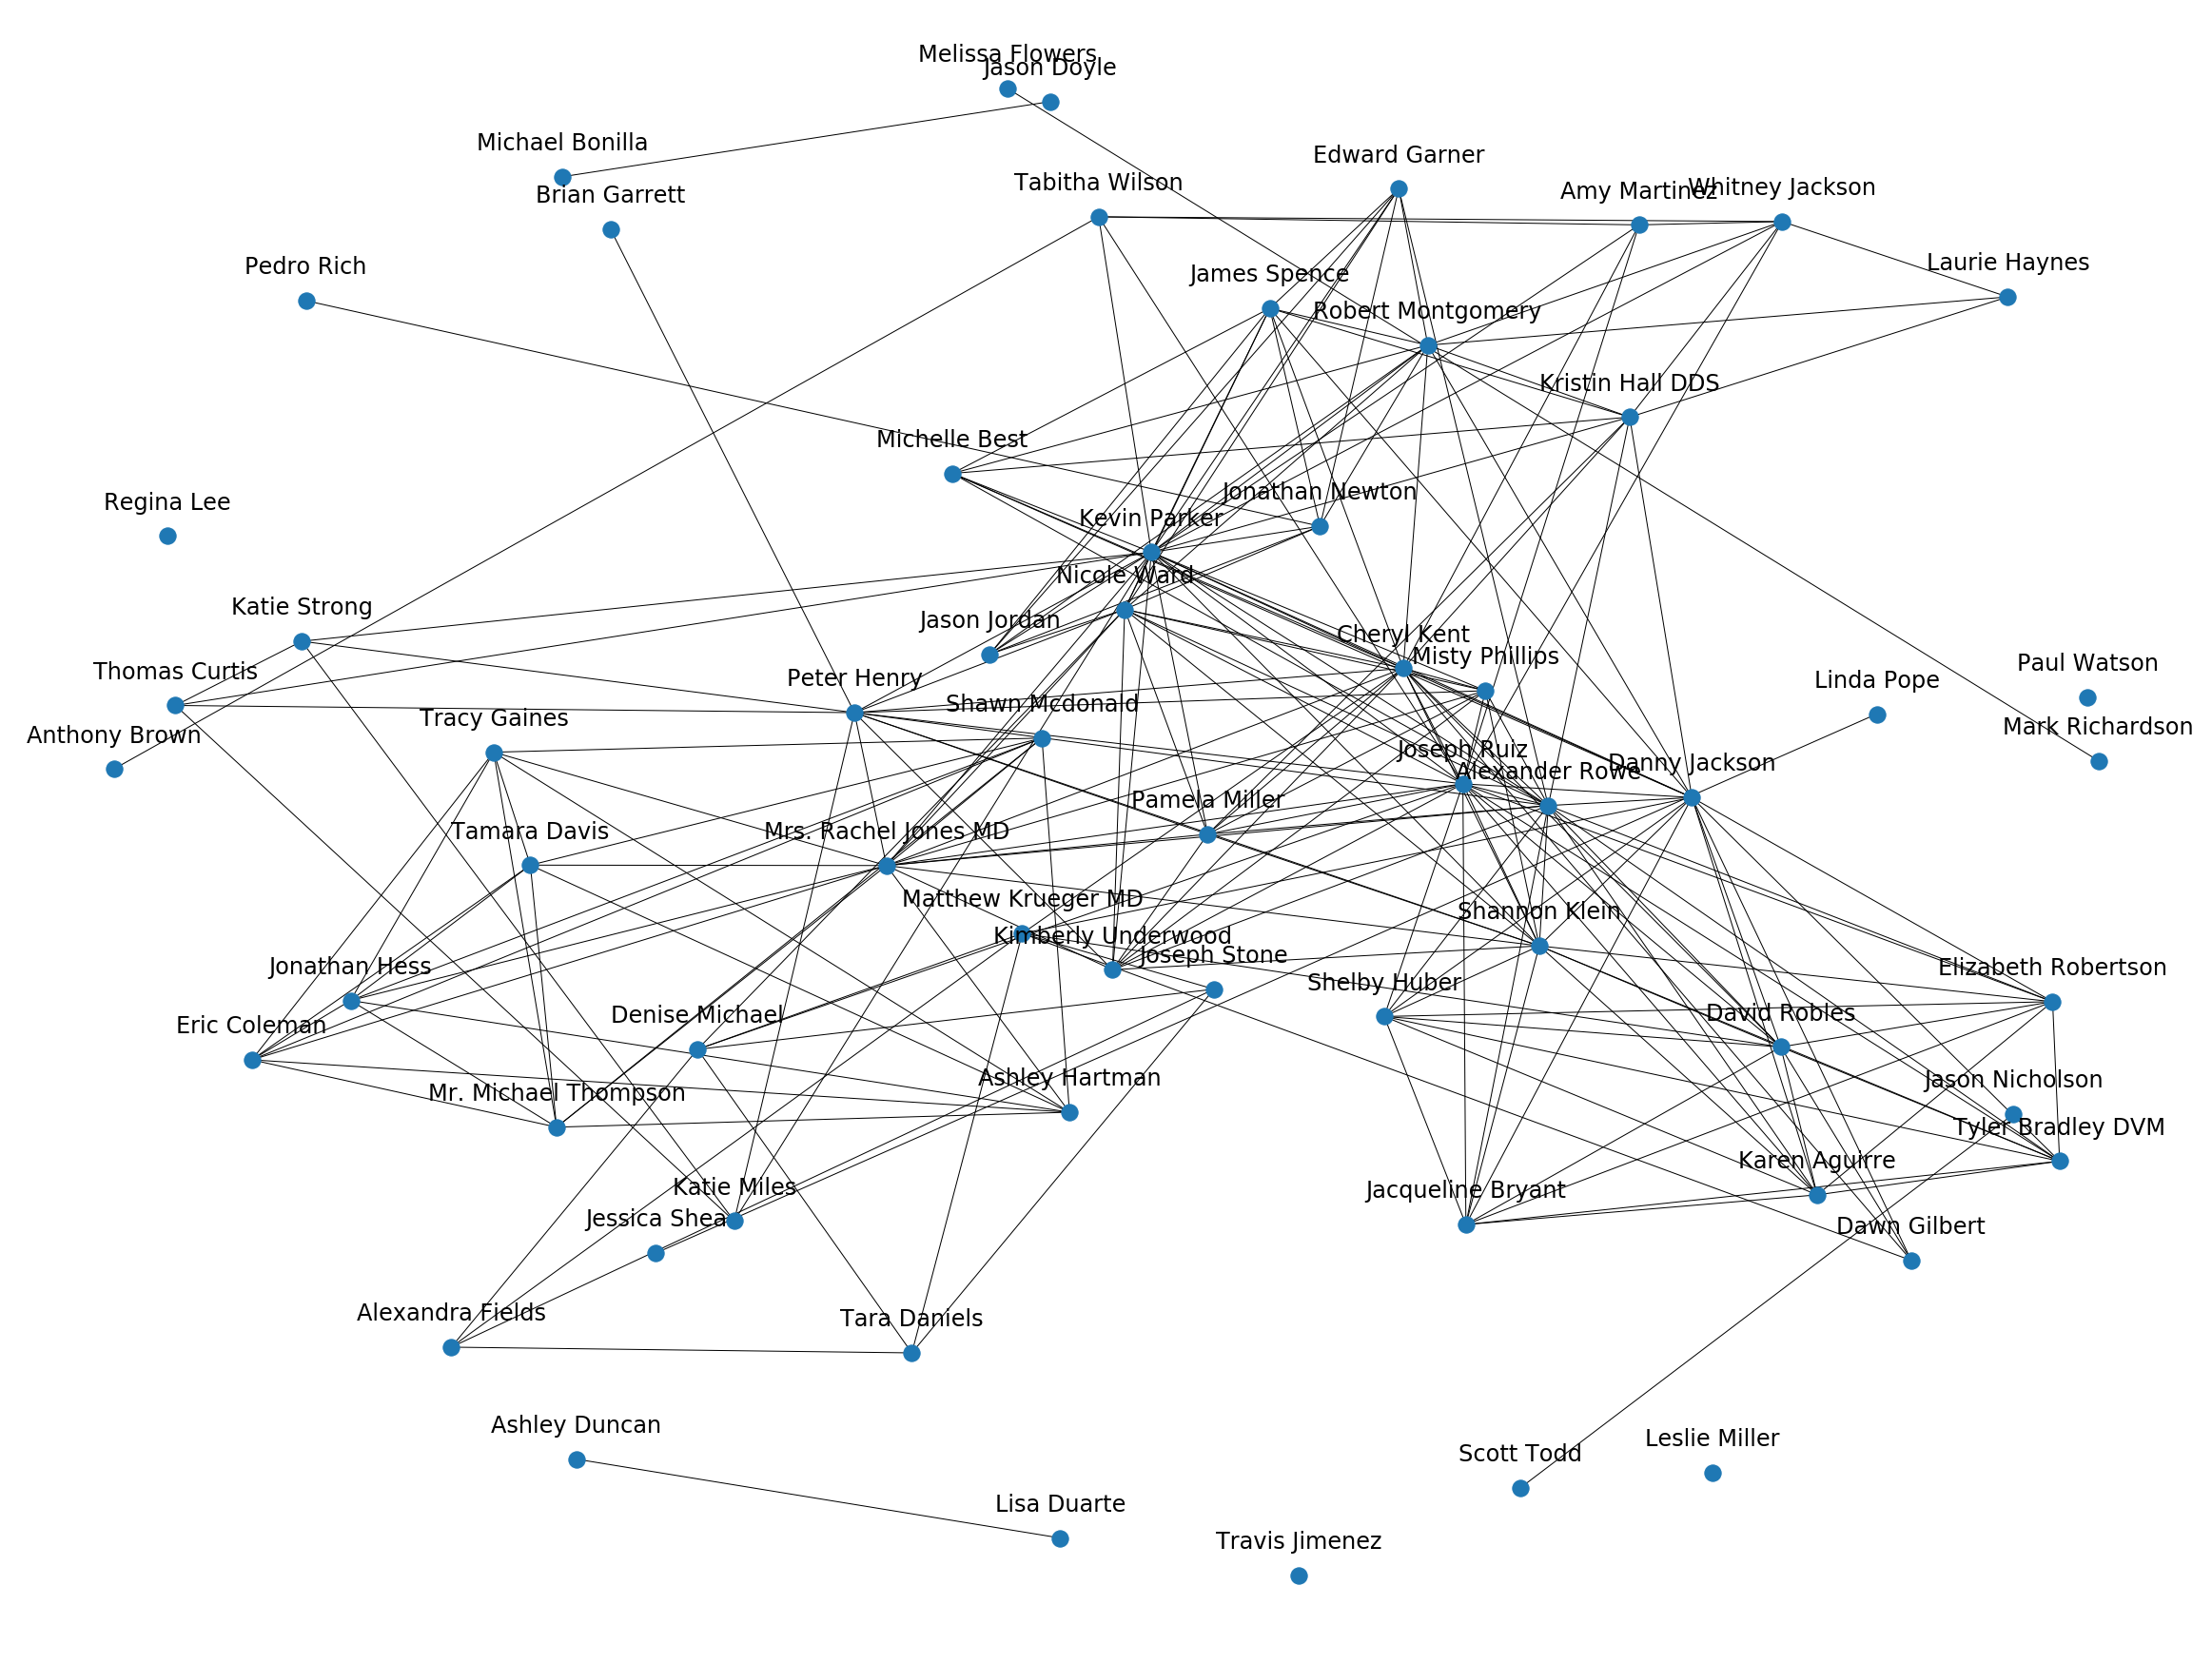

In [13]:
G, labels= buildNamedBusinessGraph()
print(len(G.degree))
pos=nx.spring_layout(G,k=1)
#nx.draw_networkx_labels(G,pos,labels,font_size=16)
nx.draw(G,pos,color=None)
saveGraphToFile(G)
for label in pos:
    x,y = pos[label]
    plt.text(x,y+0.035,s=label,horizontalalignment='center',fontsize=24)

['Heritage Trust', 'Eigg Crafts', 'Clean Planet Now', 'Eigg Electric', 'Eigg Trading', 'Eigg Construction', 'The Bothy Cuagach', 'Eigg Eco Centre', 'Eigg Huts', 'Eigg Shed', 'Eigg Primary School', 'Sandavore Farm', 'Lagerona', "Sweeney's Bothy", "Eddie's Eigg Croft", 'Kildonnan Bay Oysters', 'Eigg Shop', 'Glebe Barn', 'Laig Bay Brewing', 'Galmisdale Cafe', 'Equilibrium Eigg Massage Therapy', 'Eigg Organics', 'Roadworks', 'Kildonnan House', 'Taxi Service', 'Hebnet Cic', 'Eiggy Bread', 'Eigg Adventures', 'Eigg Camping Pods', 'LOST MAPS RECORDS LTD', 'Laig Farm', 'Fishing Co', 'A NEAD KNITWEAR', 'Refuse Collection', 'Selkie Explorers', 'Tophouse', 'TIGH AN SITHEAN', 'Health & Home Care', 'Eigg Yurts', 'Craigard Teas', 'Eigg History']


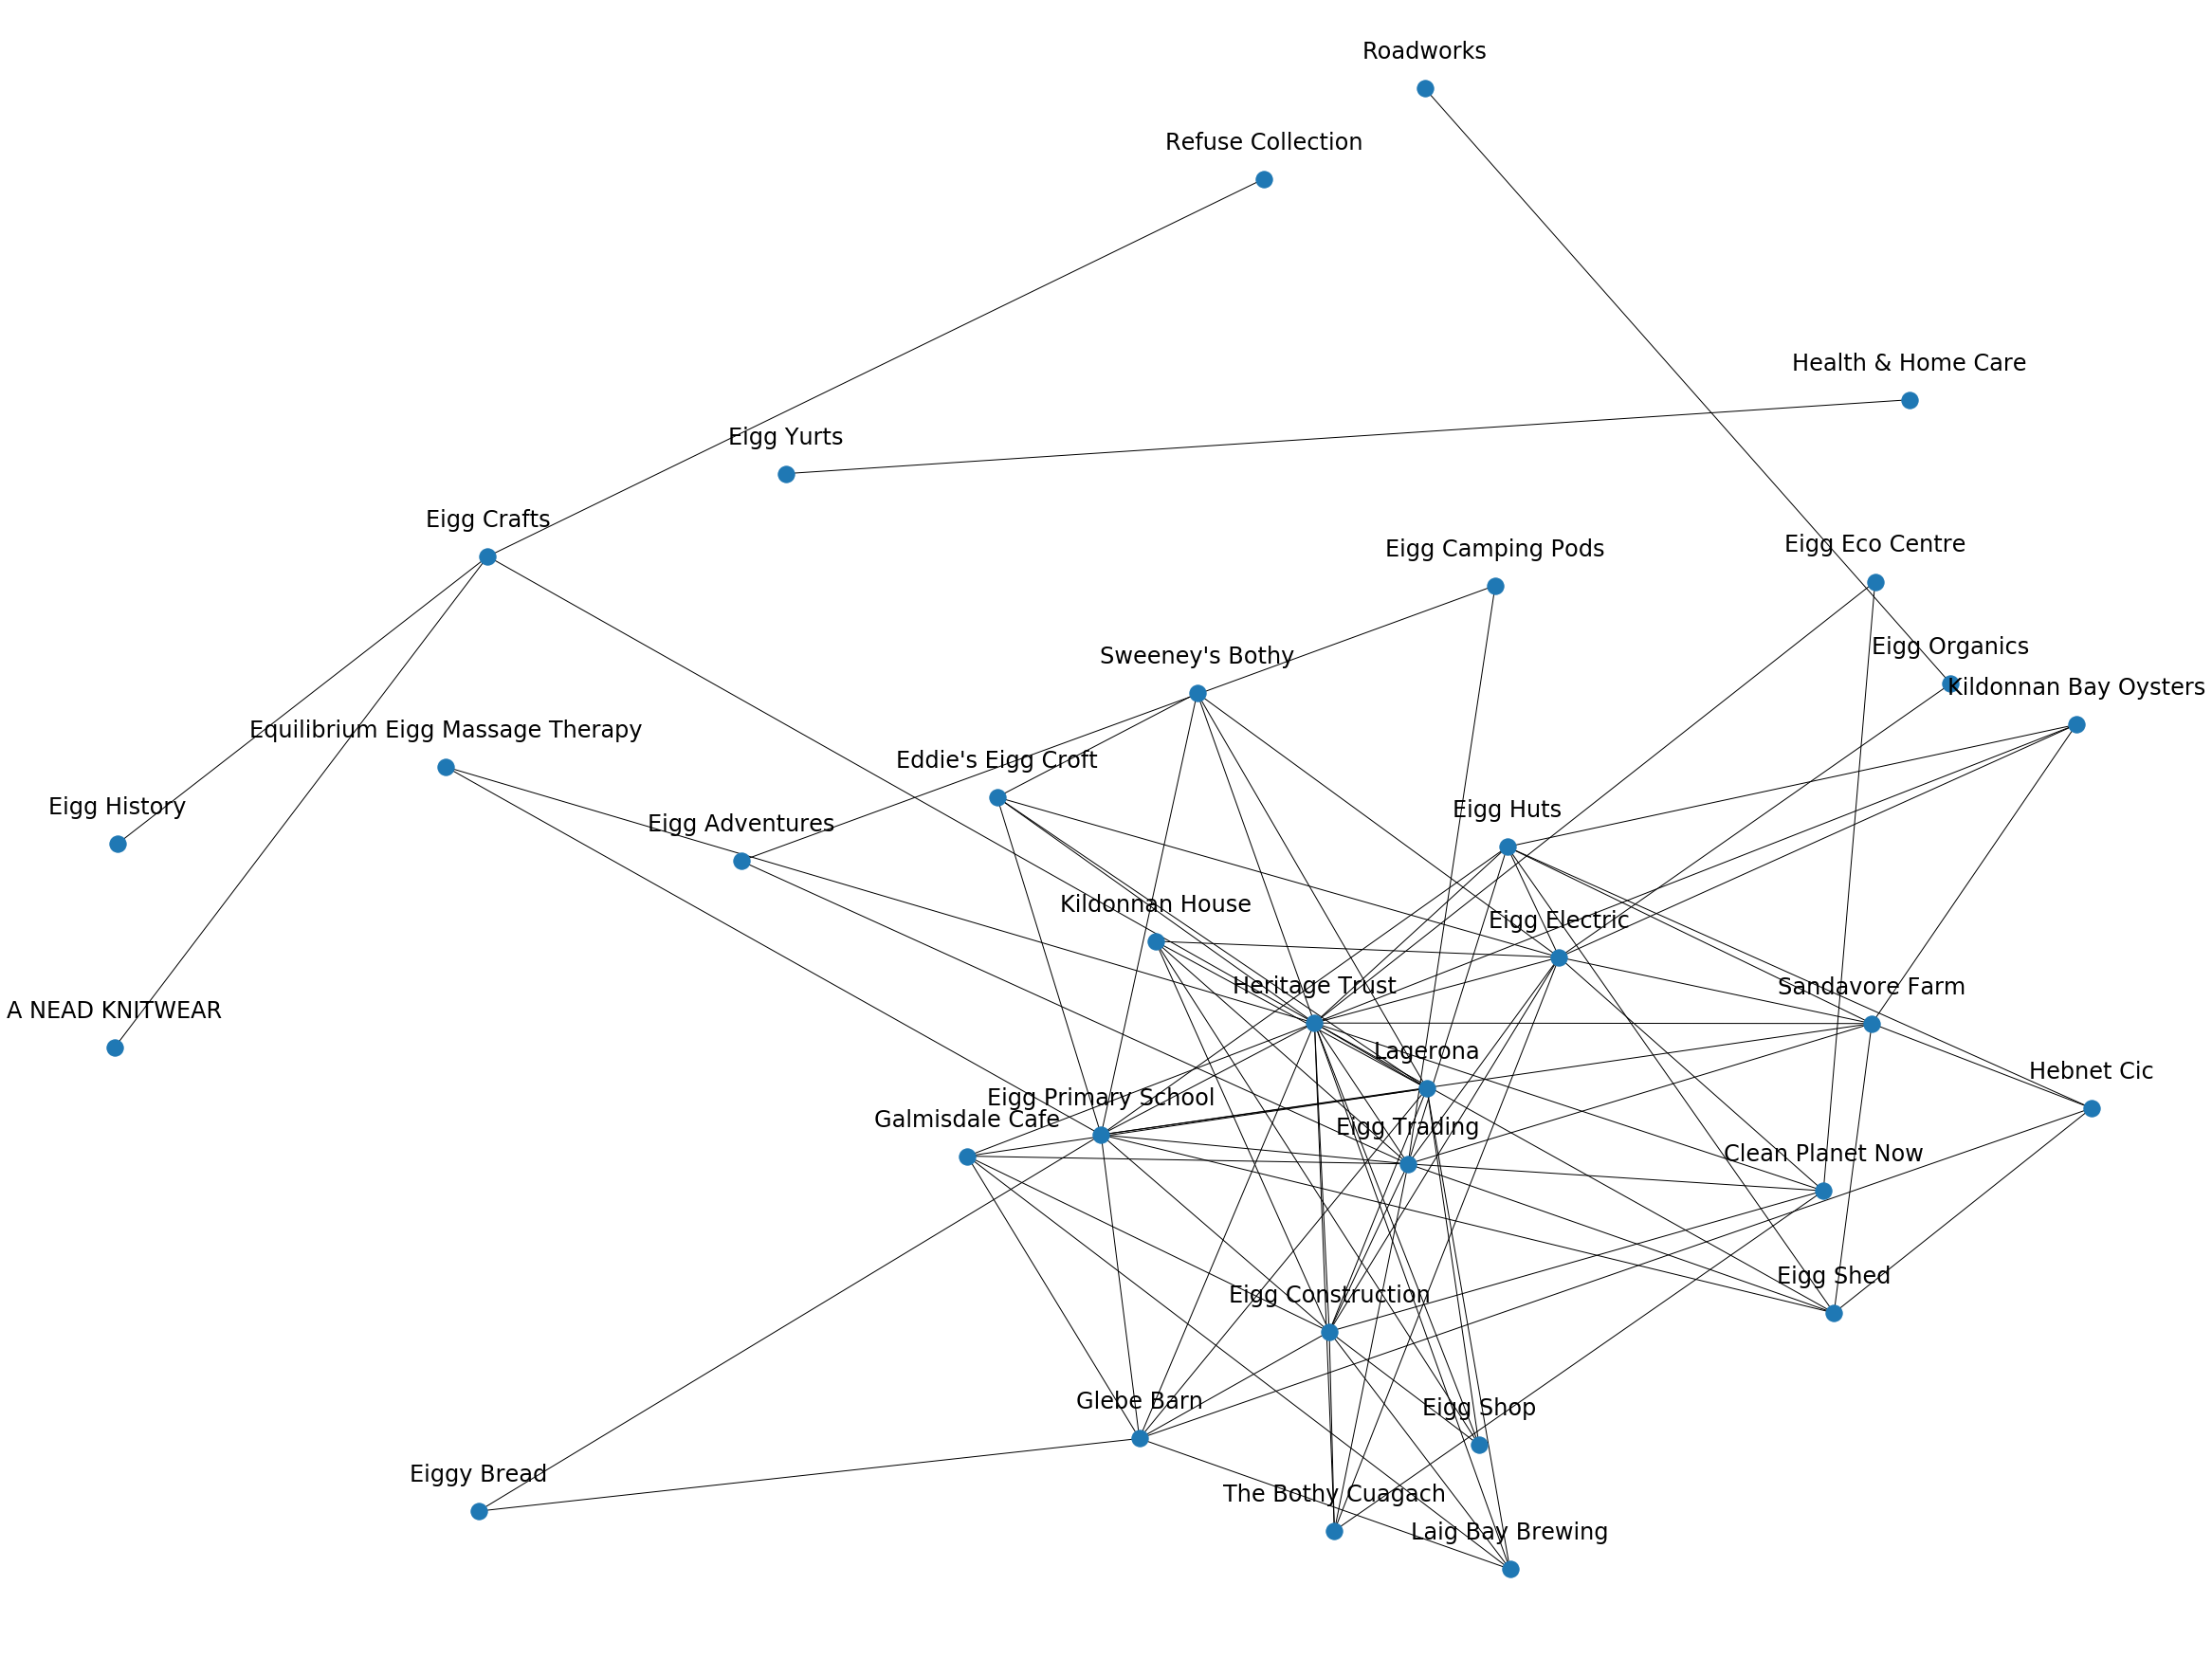

In [14]:
G, labels= buildBusinessGraph()
print(G.nodes())

G.remove_nodes_from(list(nx.isolates(G)))

pos=nx.spring_layout(G,k=1)
nx.draw(G,pos)
saveGraphToFile(G)

for label in pos:
    x,y = pos[label]
    plt.text(x,y+0.035,s=label,horizontalalignment='center',fontsize=24)

In [ ]:
list(G.edges())

In [ ]:
G, labels= buildNamedBusinessGraph(inferred=True)
pos=nx.spring_layout(G,k=1)
saveGraphToFile(G,"namedBusinessNet.txt")
#nx.draw_networkx_labels(G,pos,labels,font_size=16)
nx.draw(G,pos)
print(len(G.edges()))
for label in pos:
    x,y = pos[label]
    plt.text(x,y+0.035,s=label,horizontalalignment='center',fontsize=24)

In [ ]:
G, labels= buildBusinessGraph(inferred=True)
pos=nx.spring_layout(G,k=1)
saveGraphToFile(G,"businessNet.txt")
nx.draw_networkx_labels(G,pos,labels,font_size=16)
nx.draw(G,pos)

In [ ]:
d = inferredBusinessLocations()
dict_ = {}

for item in d:
    one,two = d[item].split(",")
    dict_[item] = [float(one),float(two)]

generateMapJSON([('./fullColMarkers/marker76.png',list(dict_.values()),list(dict_.keys()))],[(dict_,G)],'businessByLocation.txt')